# Task 1: Data Analysis and Preprocessing

This notebook performs data cleaning, exploratory data analysis (EDA), feature engineering, and class imbalance analysis for the 10 Academy Week 8&9 Fraud Detection Challenge.

## Objectives
- Clean datasets (`Fraud_Data.csv`, `creditcard.csv`, `IpAddress_to_Country.csv`).
- Perform EDA to identify fraud patterns.
- Engineer features (e.g., `time_since_signup`, `trans_freq`).
- Analyze class imbalance and propose a strategy (SMOTE).

## Datasets
- `Fraud_Data.csv`: E-commerce transactions with `user_id`, `signup_time`, `purchase_time`, etc.
- `IpAddress_to_Country.csv`: Maps IP addresses to countries.
- `creditcard.csv`: Bank transactions with `Time`, `V1`-`V28`, `Amount`, `Class`.

## Setup
- Run in a virtual environment with dependencies from `requirements.txt`.
- Ensure datasets are in `data/raw/`.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('..')  # Add parent directory to access src/
from src.data_utils import load_data, clean_data, merge_ip_to_country

%matplotlib inline
sns.set_style('whitegrid')  # Use Seaborn's whitegrid style for clean visualizations

# Load datasets
ecommerce_df = load_data('../data/raw/Fraud_Data.csv')
ip_country_df = load_data('../data/raw/IpAddress_to_Country.csv')
creditcard_df = load_data('../data/raw/creditcard.csv')

## Data Cleaning

- Remove duplicates to ensure data integrity.
- Convert `signup_time` and `purchase_time` to datetime.
- Impute missing values (median for numerical, mode for categorical).
- Merge e-commerce data with IP-to-country mapping for geolocation analysis.

In [7]:
# Clean e-commerce data
ecommerce_df = clean_data(
    ecommerce_df,
    datetime_cols=['signup_time', 'purchase_time'],
    fillna_cols={'purchase_value': 'median', 'source': 'mode', 'browser': 'mode', 'sex': 'mode'}
)

# Clean credit card data
creditcard_df = clean_data(
    creditcard_df,
    fillna_cols={'Amount': 'median'}
)

# Merge IP-to-country
ecommerce_df = merge_ip_to_country(ecommerce_df, ip_country_df)

# Save processed data
os.makedirs('data/processed', exist_ok=True)
ecommerce_df.to_csv('../data/processed/processed_ecommerce.csv', index=False)
creditcard_df.to_csv('../data/processed/processed_creditcard.csv', index=False)

## Exploratory Data Analysis (EDA)

- **Univariate Analysis**: Histograms of `purchase_value` and `Amount` to check distributions.
- **Bivariate Analysis**: Compare fraud vs. non-fraud cases across features.
- **Time Series**: Plot transaction counts by hour to identify fraud patterns.

**Hypothesis**: High `purchase_value` and transactions at unusual hours are fraud indicators.

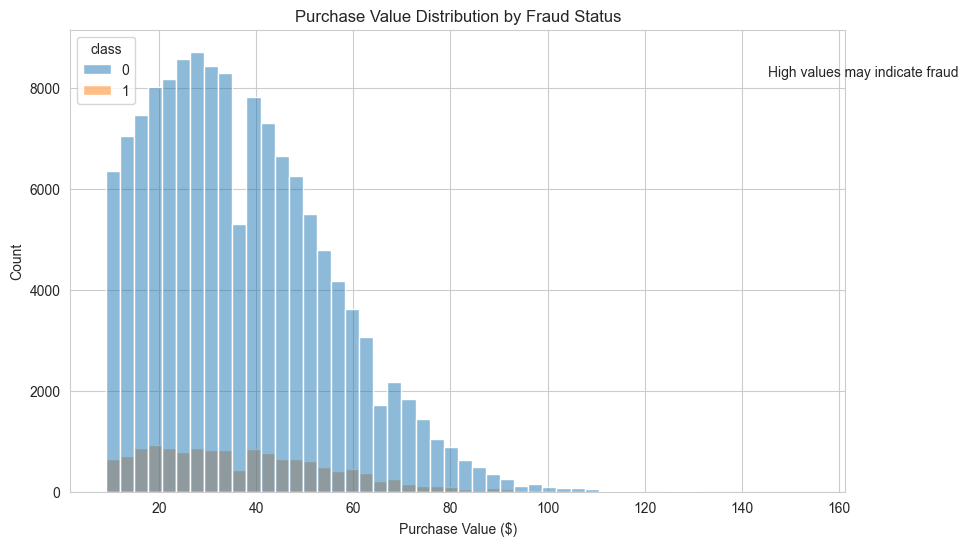

C:\Users\hp\AppData\Local\Temp\ipykernel_23672\4272984241.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ecommerce_df['purchase_hour'] = ecommerce_df['purchase_time'].dt.floor('H')


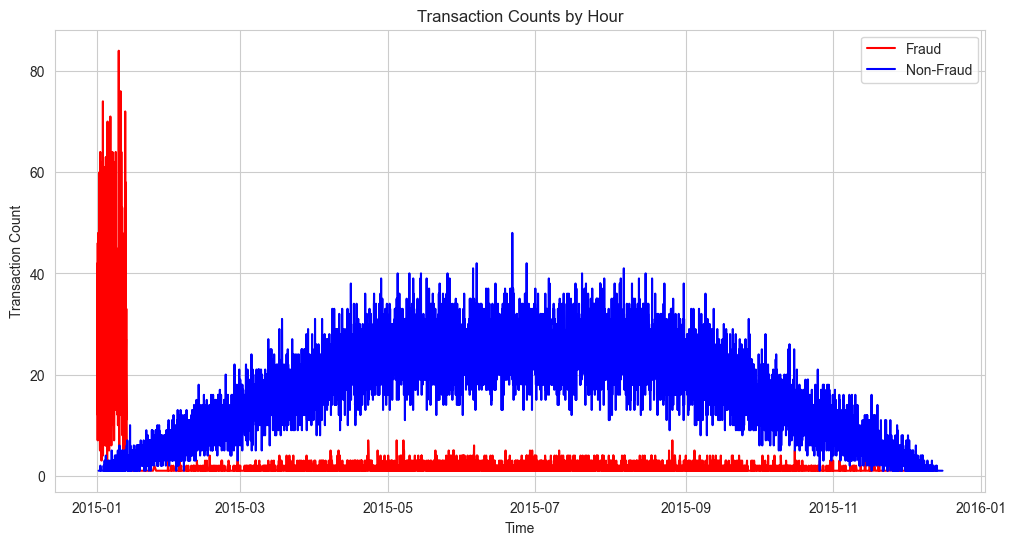

In [9]:
# Create plots directory
os.makedirs('plots', exist_ok=True)

# Histogram of purchase_value
plt.figure(figsize=(10, 6))
sns.histplot(data=ecommerce_df, x='purchase_value', hue='class', bins=50)
plt.title('Purchase Value Distribution by Fraud Status')
plt.xlabel('Purchase Value ($)') 
plt.ylabel('Count')
plt.annotate('High values may indicate fraud', xy=(0.9, 0.9), xycoords='axes fraction')
plt.savefig('../plots/purchase_value_hist.png')
plt.show()

# Time series of fraud vs. non-fraud
ecommerce_df['purchase_hour'] = ecommerce_df['purchase_time'].dt.floor('H')
fraud_counts = ecommerce_df[ecommerce_df['class'] == 1].groupby('purchase_hour').size()
non_fraud_counts = ecommerce_df[ecommerce_df['class'] == 0].groupby('purchase_hour').size()
plt.figure(figsize=(12, 6))
plt.plot(fraud_counts.index, fraud_counts, label='Fraud', color='red')
plt.plot(non_fraud_counts.index, non_fraud_counts, label='Non-Fraud', color='blue')
plt.title('Transaction Counts by Hour')
plt.xlabel('Time')
plt.ylabel('Transaction Count')
plt.legend()
plt.savefig('../plots/time_series.png')
plt.show()

## Feature Engineering

- **time_since_signup**: Duration between signup and purchase (hypothesis: fraudsters act quickly).
- **hour_of_day** and **day_of_week**: Capture temporal patterns.
- **trans_freq**: Number of transactions per user (hypothesis: high frequency may indicate fraud).

In [11]:
from src.feature_engineering import add_time_features, add_transaction_frequency

# Add time-based features
ecommerce_df = add_time_features(ecommerce_df)

# Add transaction frequency
ecommerce_df = add_transaction_frequency(ecommerce_df, 'user_id')

# Save updated data
ecommerce_df.to_csv('../data/processed/processed_ecommerce_with_features.csv', index=False)

## Class Imbalance Analysis

- Analyze class distribution for both datasets.
- Propose SMOTE for training data to balance classes, as fraud is rare but critical.

In [12]:
# Class distribution
ecommerce_class_dist = ecommerce_df['class'].value_counts(normalize=True)
creditcard_class_dist = creditcard_df['Class'].value_counts(normalize=True)
print(f'E-commerce Class Distribution:\n{ecommerce_class_dist}')
print(f'Credit Card Class Distribution:\n{creditcard_class_dist}')

# Strategy: Use SMOTE on training data to oversample the minority class (fraud),
# as missing fraud cases has high business cost.

E-commerce Class Distribution:
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64
Credit Card Class Distribution:
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


## Next Steps

- Task 2: Model building and evaluation (Logistic Regression, Random Forest).
- Prepare Interim-1 report summarizing findings.